In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import pdb
from functools import lru_cache
import sys

from scipy.stats import norm, beta
from itertools import combinations

In [2]:
def construct_grid(num_steps, grid_type='uniform'):
    
    if grid_type == 'uniform':
        grid = np.linspace(0, 1, num_steps)
    elif grid_type == 'centered':
        # Step 1: Create a linear grid
        linear_grid = np.linspace(0, 1, np.ceil(num_steps/2).astype(int))
        # Step 2: Apply a quadratic transformation
        # This transformation makes the intervals smaller around 0.5
        grid_1 = 0.5 * (np.cos(np.pi * (linear_grid - 0.5)))
        grid_2 = 1-0.5 * (np.cos(np.pi * (linear_grid - 0.5)))
        grid = np.concatenate([grid_1,grid_2])
    else:
        raise ValueError("Unsupported grid type. Choose 'uniform' or 'centered'.")
    
    return grid

## Definition of the considered covariance functions

### 1. Brownian Bridge

In [3]:
# Brownian bridge covariance function
def brownian_bridge_covariance(t1, t2, n_cal=None, scores=None, W=None, F_hat=None, joint_F_hat_vals=None):
    return min(t1, t2) - (t1 * t2)

### 2. Covariance of the analyzed empirical process

Covariance function:

$$\mathbb{E}[G_P f G_P g] = \mathbb{E}[fg] - \mathbb{E}[f] \mathbb{E}[g],$$

where $f(Z) = \sum_k \sum_l W_{kl} \mathbb{I}[\hat{s}(X,k) \leq t_1, \tilde{Y}=l]$ and $g(Z) = \sum_k \sum_l W_{kl} \mathbb{I}[\hat{s}(X,k) \leq t_2, \tilde{Y}=l]$.

This of course implies that

$$\mathbb{E}[f] = \sum_k \sum_l W_{kl} \tilde{\rho}_l \mathbb{P}[\hat{s}(X,k) \leq t_1 | \tilde{Y}=l].$$

The first term of the covariance function reads

$$\mathbb{E}[fg] = \sum_k \sum_{k'} \sum_l W_{kl} W_{k'l} \tilde{\rho}_l \mathbb{P}[\hat{s}(X,k) \leq t_1, \hat{s}(X,k') \leq t_2 | \tilde{Y}=l].$$

Estimate of the covariance function:

$$\hat{\mathbb{E}}[f] = \sum_k \sum_l W_{kl} \hat{\rho}_l \frac{1}{n_l} \sum_{i \in D_l} \mathbb{I}[\hat{s}(X_i,k) \leq t_1],$$

$$\hat{\mathbb{E}}[fg] = \sum_k \sum_{k'} \sum_l W_{kl} W_{k'l} \hat{\rho}_l \frac{1}{n_l} \sum_{i \in D_l} \mathbb{I}[\hat{s}(X_i,k) \leq t_1, \hat{s}(X_i,k') \leq t_2].$$

In [4]:
from statsmodels.distributions.empirical_distribution import ECDF

def compute_F_hat_scores(scores):
    K = max(key[0] for key in scores.keys()) + 1
    F_hat = dict()
    for l in range(K):
        for k in range(K):
            F_hat[(l,k)] = ECDF(scores[(l,k)])

    return F_hat

def compute_joint_F_hat(scores, t_values):
    joint_F_hat_vals = dict()
    K = max(key[0] for key in scores.keys()) + 1

    for t1 in t_values:
        for t2 in t_values:
            if (t1, t2) not in joint_F_hat_vals:
                joint_F_hat_vals[(t1, t2)] = dict()
            for l in range(K):
                for k in range(K):
                    s_k_l = scores[(l,k)]
                    for k_prime in range(K):
                        s_k_prime_l = scores[(l,k_prime)]
                        joint_F_hat_vals[(t1, t2)][(l, k, k_prime)] = np.mean((s_k_l <= t1) & (s_k_prime_l <= t2))

    return joint_F_hat_vals

# Covariance of the analyzed empirical process
def cov_empirical_process(t1, t2, n_cal=None, scores=None, W=None, F_hat=None, joint_F_hat_vals=None):
    K = max(key[0] for key in scores.keys()) + 1

    # Evlauate the sum
    total_sum = 0
    exp1 = 0
    exp2 = 0
    for l in range(K):
        n_l = len(scores[(l,0)])
        for k in range(K):
            exp1 += W[k,l] * n_l/n_cal * F_hat[(l,k)](t1)
            exp2 += W[k,l] * n_l/n_cal * F_hat[(l,k)](t2)
            for k_prime in range(K):
                # Joint ecdf
                joint_F_hat = joint_F_hat_vals[(t1, t2)][(l, k, k_prime)]

                # Update sum
                total_sum += W[k,l] * W[k_prime,l] * n_l/n_cal * joint_F_hat            

    cov = total_sum - exp1 * exp2
    return cov


In [5]:
# Function to generate samples from a Gaussian process
def simulate_gaussian_process(cov_function, grid, num_samples=1000, n_cal=None, scores=None, W=None, F_hat=None, joint_F_hat_vals=None):
    # Compute the covariance matrix
    n = len(grid)
    Sigma = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            Sigma[i, j] = cov_function(grid[i], grid[j], n_cal, scores, W, F_hat, joint_F_hat_vals)
    
    # Add a small value to the diagonal for numerical stability
    Sigma += 1e-6 * np.eye(n)
    
    # Mean vector
    mu = np.zeros((n,))
    
    # Generate samples
    samples = np.random.multivariate_normal(mu, Sigma, size=(num_samples))
       
    return samples

In [6]:
def simulate_supremum(cov_function, h, num_samples = 1000, grid_type="uniform", n_cal=None, scores=None, W=None):
    num_steps = int(np.ceil(1.0 / h))
    grid = construct_grid(num_steps, grid_type)
    
    if scores is not None:
        F_hat = compute_F_hat_scores(scores)

        joint_F_hat_vals = compute_joint_F_hat(scores, grid)
        print('Pre-evaluation of the joint ecdf completed.')
        sys.stdout.flush()
    else:
        F_hat = None
        joint_F_hat_vals = None

    samples = simulate_gaussian_process(cov_function, grid, num_samples, n_cal, scores, W, F_hat, joint_F_hat_vals)
    suprema = np.max(np.abs(samples),1)
    
    expected_supremum = np.mean(suprema)
    return expected_supremum

In [7]:
@lru_cache(maxsize=None)
def richardson_recursive(h, func, j, k):
    """Recursive function for Richardson extrapolation."""
    if j == 0:
        return func(h)
    if k == 0:
        return func(h/np.power(2,j))
    else:
        R1 = richardson_recursive(h, func, j, k-1)
        R2 = richardson_recursive(h, func, j-1, k-1)
        return (np.power(2.0,k) * R1 - R2) / (np.power(2.0,k) - 1.0)
    
def richardson_extrapolation(h, func, max_j):
    """Perform Richardson extrapolation using recursion and memoization."""
    return richardson_recursive(h, func, max_j, max_j)


## Experiment
### 1. Brownian Bridge

For the standard Brownian Bridge, the expected value of the supremum is known and is equal to
\begin{align*}
\mathbb{E}\left[\underset{t}{\text{sup}} |B_F (t)| \right] &= \mathbb{E}\left[\underset{t}{\text{sup}} |B_{U(0,1)} (t)| \right]\\
&= \mathbb{E}\left[\underset{t}{\text{sup}} |B(t)| \right]\\
&= \sqrt{\frac{\pi}{2}} \log 2.
\end{align*}

In what follows, we study how the Richardon extrapolation method, combined with a Monte Carlo simulation of the empirical process evaluated on a grid of fixed thinness, allows to get a good approximation from below of the true expected value of the supremum of a standard Brownian bridge. In particular, we aim to investigate the optimal combination of grid thinness and order of the Richardson extrapolation method, which can be used in practice to estimate the expected value of the supremum of the empirical process considered in our work. This would lead to a novel and asymptotic finite sample correction which enters the adaptive conformal method discussed in our work.

In [8]:
# Experiment parameters
covariance_model = "brownian_bridge"

# number of Monte Carlo iterations
"""
M = 1000000 con Tmax=800 è troppo alto, mi crasha tutto.
Canceled future for execute_request message before replies were done
The Kernel crashed while executing code in the the current cell or a previous cell. Please review the code in the cell(s)
to identify a possible cause of the failure. Click here for more info. View Jupyter log for further details.
"""
M = 1000000

# Grid parameters
grid_type = 'uniform'
#grid_type = 'centered'

# Thinness of the considered grid
T_values = np.array([100,200,400,800,1600])
Tmax = T_values[-1]

# Orders of the Richardson interpolation method
r_order = np.array([1,2])

# Define the covariance function
cov_function = brownian_bridge_covariance


In [9]:
func = lambda h: simulate_supremum(cov_function, h=h, num_samples=M, grid_type=grid_type)

seed = 20240809
# Output file
outfile_prefix = covariance_model + "_M" + str(M) + "_Tmax" + str(Tmax) + "_seed" + str(seed)
print("Output file: {:s}.".format("results/"+outfile_prefix), end="\n")

np.random.seed(seed)
results = pd.DataFrame()
for T in T_values:
    estimate = func(1/T)
    method = "Standard"
    res = pd.DataFrame({'T':[T], 'Method':[method], 'estimate':[estimate]})
    results = pd.concat([results,res])
    if T < T_values[-2]:
        for r in r_order:
            estimate = richardson_extrapolation(1/T, func, r)
            method = "Richardson ({:d})".format(r)
            res = pd.DataFrame({'T':[T*np.power(2,r)], 'Method':[method], 'estimate':[estimate]})
            results = pd.concat([results,res])
    elif T==T_values[-2]:
        r=1
        estimate = richardson_extrapolation(1/T, func, r)
        method = "Richardson ({:d})".format(r)
        res = pd.DataFrame({'T':[T*np.power(2,r)], 'Method':[method], 'estimate':[estimate]})
        results = pd.concat([results,res])
    else:
        pass  
    
    print(T)

# Save results
outfile = "results/" + outfile_prefix + ".txt"
results.to_csv(outfile, index=False, float_format="%.5f")

Output file: results/brownian_bridge_M1000000_Tmax1600_seed20240809.
100
200
400
800
1600


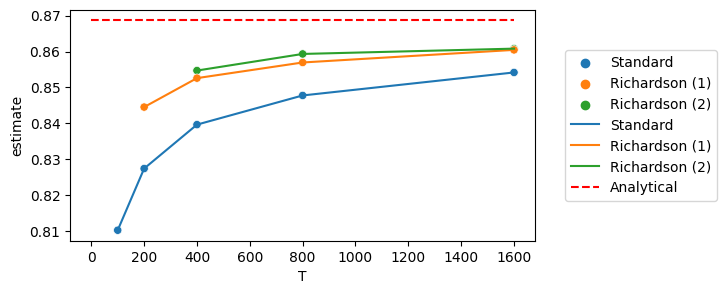

In [10]:
# Plot results
M = 1000000
seed = 20240809
Tmax = 1600
T_values = np.array([100,200,400,800,1600])
outfile_prefix = covariance_model + "_M" + str(M) + "_Tmax" + str(Tmax) + "_seed" + str(seed)
outfile = "results/" + outfile_prefix + ".txt"
results = pd.read_csv(outfile)
# Output file
outfile_prefix = covariance_model + "_M" + str(M) + "_Tmax" + str(Tmax) + "_seed" + str(seed)
outfile_png = "figures/" + outfile_prefix + ".png"
target = np.sqrt(np.pi/2)*np.log(2)
plt.figure(figsize=(6, 3))
sns.scatterplot(data=results, x='T', y='estimate', hue='Method')
sns.lineplot(data=results, x='T', y='estimate', hue='Method', errorbar=None)
#plt.hlines(target, 0, np.max(T_values*np.power(2,np.max(r_order))), color="red", label="Analytical")
plt.hlines(target, 0, np.max(T_values), color="red", linestyle='--', label="Analytical")
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.savefig(outfile_png, bbox_inches='tight')

#### Studying the variability of Richardson's extrapolation
Here, we aim to create a plot which displays the variability of the estimates obtained with each method, as $M$ varies.

##### Tmax=800

In [11]:
# Fixed parameters of the experiment
# Experiment parameters
covariance_model = "brownian_bridge"

# Grid parameters
grid_type = 'uniform'

# Thinness of the considered grid
T = 200

# Orders of the Richardson interpolation method
r_order = np.array([1,2])

# Define the covariance function
cov_function = brownian_bridge_covariance
B = 20

M_vals = [1000, 5000, 10000, 50000]
#M_vals = [100, 500]
seed = 0

In [12]:
# Output file
outfile_prefix = covariance_model + "_Tmax" + str(4*T) + "_varyingM"
outfile_prefix += "_seed" + str(seed)
print("Output file: {:s}.".format("results/" + outfile_prefix), end="\n")

np.random.seed(seed)
results = pd.DataFrame()
for M in M_vals:

    for b in range(B):
        # Define Monte Carlo simulation
        func = lambda h: simulate_supremum(cov_function, h=h, num_samples=M, grid_type=grid_type)

        # Standard
        estimate = func(1/(4*T))
        method = "Standard"
        res = pd.DataFrame({'T':[4*T], 'Method':[method], 'estimate':[estimate], 'b':[b], 'M':[M]})
        results = pd.concat([results,res])

        # Richardson 1
        r=1
        estimate = richardson_extrapolation(1/(2*T), func, r)
        method = "Richardson ({:d})".format(r)
        res = pd.DataFrame({'T':[(2*T)*np.power(2,r)], 'Method':[method], 'estimate':[estimate], 'b':[b], 'M':[M]})
        results = pd.concat([results,res])

        # Richardson 2
        r=2
        estimate = richardson_extrapolation(1/T, func, r)
        method = "Richardson ({:d})".format(r)
        res = pd.DataFrame({'T':[T*np.power(2,r)], 'Method':[method], 'estimate':[estimate], 'b':[b], 'M':[M]})
        results = pd.concat([results,res])
    
    print(M)

# Save results
outfile = "results/" + outfile_prefix + ".txt"
results.to_csv(outfile, index=False, float_format="%.5f")


Output file: results/brownian_bridge_Tmax800_varyingM_seed0.


/var/folders/wx/7r3x1_l13dsfx_jds0xhf1f00000gn/T/ipykernel_10598/938498176.py:18: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mu, Sigma, size=(num_samples))


1000
5000
10000
50000


In [13]:
# Load the results for the plot
# Reload results and redo figures if needed
seed = 0
T = 200
covariance_model = "brownian_bridge"
outfile_prefix = covariance_model + "_Tmax" + str(4*T) + "_varyingM"
outfile_prefix += "_seed" + str(seed)
outfile = "results/" + outfile_prefix + ".txt"
results = pd.read_csv(outfile)

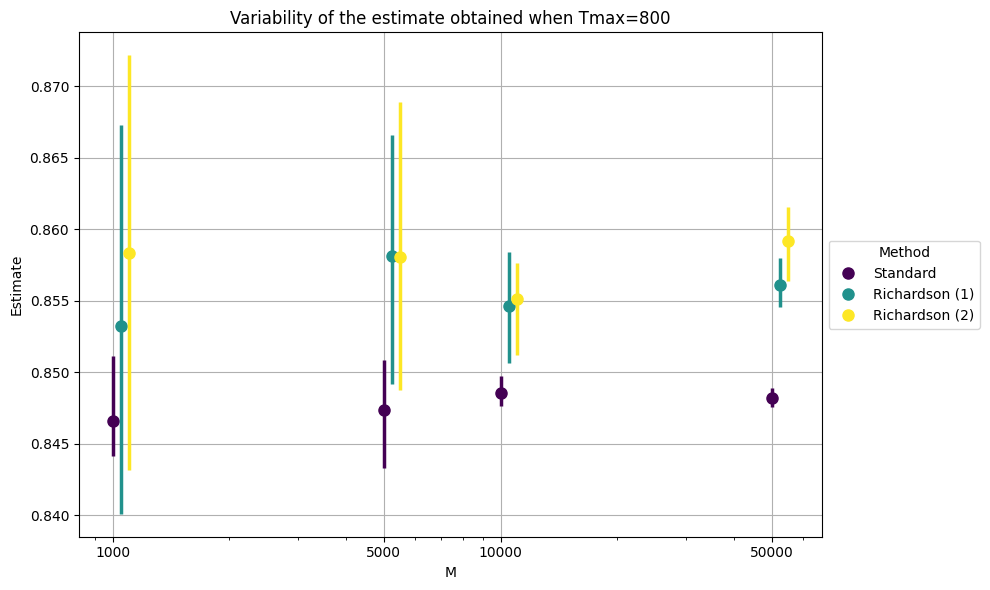

In [14]:
outfile_png = "figures/" + outfile_prefix + ".png"

# Plot of the results
# Calculate the statistics
aggregated_data = results.groupby(['M', 'Method']).agg(
    mean_estimate=('estimate', 'mean'),
    quantile_25=('estimate', lambda x: x.quantile(0.25)),
    quantile_75=('estimate', lambda x: x.quantile(0.75))
).reset_index()

# Define the offset amount and line width
offset_amount = 0.05
line_width = 2.5

# Preparing the plot
plt.figure(figsize=(10, 6))
methods = results['Method'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(methods)))

for i, method in enumerate(methods):
    method_data = aggregated_data[aggregated_data['Method'] == method]
    # Applying the offset
    plt.plot(method_data['M'] * (1 + i * offset_amount), method_data['mean_estimate'], 'o', color=colors[i], label=method, markersize=8)
    plt.vlines(method_data['M'] * (1 + i * offset_amount), method_data['quantile_25'], method_data['quantile_75'], color=colors[i], linewidth=line_width)

# Set x-axis to logarithmic scale
plt.xscale('log')

# Set the original M values as tick labels
plt.xticks(aggregated_data['M'].unique(), labels=aggregated_data['M'].unique())

# Adding labels and title
plt.xlabel('M')
plt.ylabel('Estimate')
plt.title('Variability of the estimate obtained when Tmax=800')

# Moving the legend outside the plot, to the right, and centered vertically
plt.legend(title="Method", loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()

plt.savefig(outfile_png, bbox_inches='tight')

##### Tmax=1600

In [16]:
# Fixed parameters of the experiment
# Experiment parameters
covariance_model = "brownian_bridge"

# Grid parameters
grid_type = 'uniform'

# Thinness of the considered grid
T = 400

# Orders of the Richardson interpolation method
r_order = np.array([1,2])

# Define the covariance function
cov_function = brownian_bridge_covariance

In [17]:
B = 20

M_vals = [1000, 5000, 10000, 50000]
seed = 0

# Output file
outfile_prefix = covariance_model + "_Tmax" + str(4*T) + "_varyingM"
outfile_prefix += "_seed" + str(seed)
print("Output file: {:s}.".format("results/" + outfile_prefix), end="\n")

np.random.seed(seed)
results = pd.DataFrame()
for M in M_vals:

    for b in range(B):
        # Define Monte Carlo simulation
        func = lambda h: simulate_supremum(cov_function, h=h, num_samples=M, grid_type=grid_type)

        # Standard
        estimate = func(1/(4*T))
        method = "Standard"
        res = pd.DataFrame({'T':[4*T], 'Method':[method], 'estimate':[estimate], 'b':[b], 'M':[M]})
        results = pd.concat([results,res])

        # Richardson 1
        r=1
        estimate = richardson_extrapolation(1/(2*T), func, r)
        method = "Richardson ({:d})".format(r)
        res = pd.DataFrame({'T':[(2*T)*np.power(2,r)], 'Method':[method], 'estimate':[estimate], 'b':[b], 'M':[M]})
        results = pd.concat([results,res])

        # Richardson 2
        r=2
        estimate = richardson_extrapolation(1/T, func, r)
        method = "Richardson ({:d})".format(r)
        res = pd.DataFrame({'T':[T*np.power(2,r)], 'Method':[method], 'estimate':[estimate], 'b':[b], 'M':[M]})
        results = pd.concat([results,res])
    
    print(M)

    

# Save results
outfile = "results/" + outfile_prefix + ".txt"
results.to_csv(outfile, index=False, float_format="%.5f")

Output file: results/brownian_bridge_Tmax1600_varyingM_seed0.


KeyboardInterrupt: 

In [18]:
# Load the results for the plot
# Reload results and redo figures if needed
seed = 0
T = 400
covariance_model = "brownian_bridge"
outfile_prefix = covariance_model + "_Tmax" + str(4*T) + "_varyingM"
outfile_prefix += "_seed" + str(seed)
outfile = "results/" + outfile_prefix + ".txt"
results = pd.read_csv(outfile)

outfile_png = "figures/" + outfile_prefix + ".png"

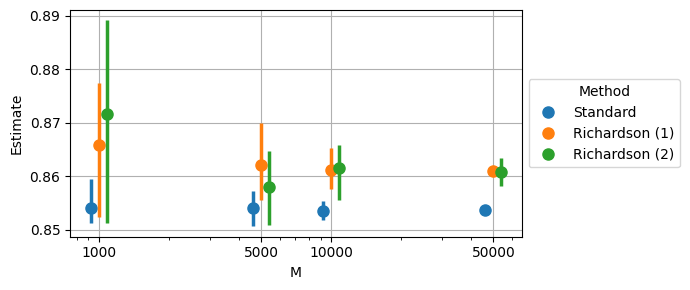

In [31]:
# Plot of the results
# Calculate the statistics
aggregated_data = results.groupby(['M', 'Method']).agg(
    mean_estimate=('estimate', 'mean'),
    quantile_25=('estimate', lambda x: x.quantile(0.25)),
    quantile_75=('estimate', lambda x: x.quantile(0.75))
).reset_index()

# Define the offset amount and line width
offset_amount = 0.08
line_width = 2.5

# Preparing the plot
plt.figure(figsize=(7, 3))
methods = results['Method'].unique()
#colors = plt.cm.viridis(np.linspace(0, 1, len(methods)))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, method in enumerate(methods):
    method_data = aggregated_data[aggregated_data['Method'] == method]
    # Applying the offset
    offset = (i - (len(methods) - 1) / 2) * offset_amount
    plt.plot(method_data['M'] * (1 + offset), method_data['mean_estimate'], 'o', color=colors[i], label=method, markersize=8)
    plt.vlines(method_data['M'] * (1 + offset), method_data['quantile_25'], method_data['quantile_75'], color=colors[i], linewidth=line_width)

# Set x-axis to logarithmic scale
plt.xscale('log')

# Set the original M values as tick labels
plt.xticks(aggregated_data['M'].unique(), labels=aggregated_data['M'].unique())

# Adding labels and title
plt.xlabel('M')
plt.ylabel('Estimate')
#plt.title('Variability of the estimates')

# Moving the legend outside the plot, to the right, and centered vertically
plt.legend(title="Method", loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()

plt.savefig(outfile_png, bbox_inches='tight')

In [41]:
# Reload results and redo figures if needed
M = 1000000
seed = 0
Tmax = 1600
T_values = np.array([100,200,400,800,1600])
outfile_prefix = covariance_model + "_M" + str(M) + "_Tmax" + str(Tmax) + "_seed" + str(seed)
outfile = "results/" + outfile_prefix + ".txt"
results = pd.read_csv(outfile)

outfile_png = "figures/" + outfile_prefix + ".png"
target = np.sqrt(np.pi/2)*np.log(2)
# Plot results
sns.scatterplot(data=results, x='T', y='estimate', hue='Method')
sns.lineplot(data=results, x='T', y='estimate', hue='Method', errorbar=None)
#plt.hlines(target, 0, np.max(T_values*np.power(2,np.max(r_order))), color="red", label="Estimated target")
plt.hlines(target, 0, np.max(T_values), color="red", label="Estimated target")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(outfile_png, bbox_inches='tight')